**Saad Khan and Veer Khosla**

Fall 2024

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 2: Implement single layer network to test softmax activation and cross-entropy loss

You will first implement and test out the softmax activation and cross-entropy loss in a single layer net before embedding it in a more complex multi-layer network.

### 2a. Load in preprocessed STL-10 data

Use your automated preprocessing function to load in the STL-10 data in the following split:
- 3000 training samples
- 750 test samples
- 1000 validation samples
- 250 samples for development

In [2]:
# YOUR CODE HERE
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(n_train_samps=3000, n_test_samps=750, n_valid_samps=1000, n_dev_samps=250)


### 2b. Implement the following functions

In `softmax_layer.py`, implement the following methods in the base class `SoftmaxLayer`:

- `fit`
- `net_in`
- `predict`
- `one_hot`
- `accuracy`
- `activation` (softmax) $f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}}$ where $x_i$ are the "net in" values and there are $C$ output neurons (one per input class). $f(x_i)$ is the activation values of each output neuron $i$. Since this is softmax, it is the probability that a given input belongs to the class $i$ coded by the output neuron.
- `loss` (cross-entropy) $L(x_m) = -\frac{1}{B}\sum_{b=1}^B{Log \left (\frac{e^{x_m}}{\sum_{n=1}^C e^{x_n}}\right )}$. $m$ is the correct class for the $b^{th}$ input. $x_m$ is the output neuron activation for the correct class, $x_n$ is the output neuron activation for all of the classes (in the sum). The batch size is $B$, so the loss is averaged over each mini-batch of inputs. The expression in the $Log$ is just the softmax.
- `gradient` (for softmax/cross-entropy)

You're welcome to work in any order, but I recommend starting with `fit` because as you work though it, you should recognize why we need most of the other methods. You can finish `fit` or branch off as you need the other methods.

### 2c. Test key functions

In [3]:
from softmax_layer import SoftmaxLayer

In [4]:
# Let's generate some small Gaussian weights equal to the length of an image feature vector
rng = np.random.default_rng(0)
randWts = rng.normal(loc=0, scale=0.01, size=(x_dev.shape[1], 10))
b = 1
softmaxNet = SoftmaxLayer(-1)

# Fake data for consistent debugging
test_imgs = rng.random(size=(15, x_dev.shape[1])) - 0.5
test_labels = rng.integers(low=0, high=6, size=(15,))

#### Test the `onehot` function

In [5]:
y_test1 = np.array([1, 2, 2, 0, 1, 3])
c_test = 4
y_one_hot = softmaxNet.one_hot(y_test1, c_test)
print(f'Your one hot vectors:\n{y_one_hot}')

Your one hot vectors:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Your one hot vectors should look like:

    [[0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 1. 0.]
     [1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 0. 1.]]

#### Test the `loss`,  `net_in`, softmax `activation` functions

In [6]:
lossNoReg, lossReg = softmaxNet.test_loss(randWts, b, test_imgs, test_labels)
print(f'The loss (without regularization) is {lossNoReg:.2f} and it should approx be 2.30')
print(f'The loss (with 0.5 regularization) is {lossReg:.2f} and it should approx be 3.07')

net in shape=(15, 10), min=0.5846647992996103, max=1.4113966700992964
Should be
net in shape=(15, 10), min=0.584664799299611, max=1.411396670099296

net act shape=(15, 10), min=0.06651346722629758, max=0.14392819816212585
Should be
net act shape=(15, 10), min=0.0665134672262976, max=0.1439281981621258

The loss (without regularization) is 2.30 and it should approx be 2.30
The loss (with 0.5 regularization) is 3.07 and it should approx be 3.07


#### Test the `gradient` function

In [7]:
grad_wts, grad_b = softmaxNet.test_gradient(randWts, b, test_imgs, test_labels, 10)
print()
print(f'1st few Wt gradient values are {grad_wts[:4,0]}\nand should be                  [ 0.009 -0.047  0.088  0.01 ] ')
print(f'1st few Wt bias values are {grad_b[:4]}\nand should be              [-0.429  0.034  0.034 -0.098]')

net in: (15, 10), 0.5846647992996103, 1.4113966700992964
net in 1st few values of 1st input are:
[0.798 1.095 0.969 0.9   0.958]
and should be
[0.798 1.095 0.969 0.9   0.958]
net act 1st few values of 1st input are:
[0.078 0.105 0.092 0.086 0.091]
and should be
[0.078 0.105 0.092 0.086 0.091]
y one hot: (15, 10), sum is 15.0.
You should know what the sum should be :)

1st few Wt gradient values are [ 0.009 -0.047  0.088  0.01 ]
and should be                  [ 0.009 -0.047  0.088  0.01 ] 
1st few Wt bias values are [-0.429  0.034  0.034 -0.098]
and should be              [-0.429  0.034  0.034 -0.098]


#### Test `fit` function

In [8]:
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev,
                              n_epochs=600,
                              mini_batch_sz=250,
                              r_seed=0)

Iteration 100/600, Loss: 0.1881
Iteration 200/600, Loss: 0.0926
Iteration 300/600, Loss: 0.0596
Iteration 400/600, Loss: 0.0428
Iteration 500/600, Loss: 0.0315
Iteration 600/600, Loss: 0.0254
Training completed. 600 epochs, 1 iterations per epoch.


Given the random mini-batch sampling process, you may get different specific numbers, but the loss should generally decrease over iterations. You should get something like this:

```
Starting to train network...There will be 600 epochs and 600 iterations total, 1 iter/epoch.
  Completed iter 0/600. Training loss: 2.37.
  Completed iter 100/600. Training loss: 2.13.
  Completed iter 200/600. Training loss: 2.01.
  Completed iter 300/600. Training loss: 1.92.
  Completed iter 400/600. Training loss: 1.87.
  Completed iter 500/600. Training loss: 1.78.
Finished training!
```

##### Plot the loss

It should look noisy, but decrease on average.

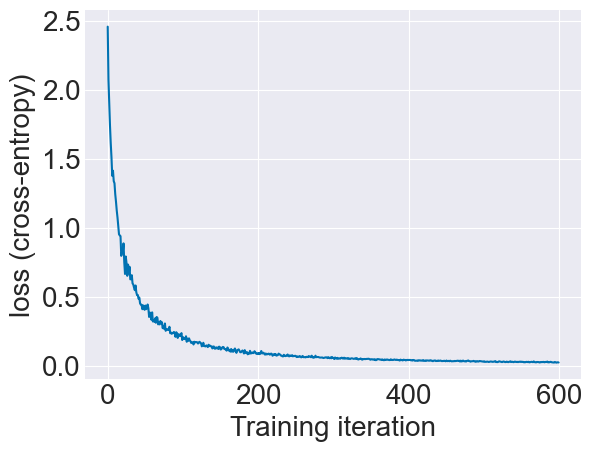

In [9]:
def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()

plot_cross_entropy_loss(loss_history)

### 2d. Questions

**Question 1.** What do you think the decrease in loss over the epochs tells us about the state of the training process? What's the future potential for improvement like?

**Answer 1:** 

Decrease in loss continues to slow down as training continues, while loss goes from a very fast rate of improvement before slowing down and improving less with every iteration.



**Question 2.** Below, write code to test regularization with training: check to make sure that the loss starts at ~155 for `reg=100`. Once you get this working, play around with the regularization parameter. You can drastically change the magnitude, but it should always remain nonnegative. 

(i) How does regularization affect the training loss and **why**?

(ii) Make a plot that shows the ~155 initial loss for `reg=100`.

**Answer 2:** 


Iteration 100/600, Loss: 85.7461
Iteration 200/600, Loss: 87.4609
Iteration 300/600, Loss: 88.5947
Iteration 400/600, Loss: 87.3938
Iteration 500/600, Loss: 87.6460
Iteration 600/600, Loss: 89.2162
Training completed. 600 epochs, 1 iterations per epoch.


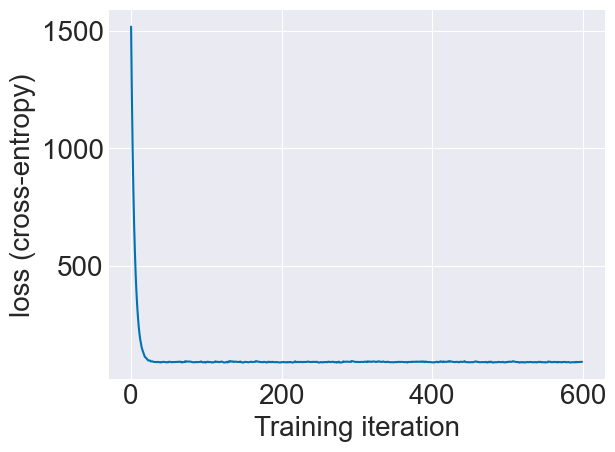

In [10]:
#test regularization

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev,
                              n_epochs=600,
                              mini_batch_sz=250,
                              r_seed=0, reg=1000)

plot_cross_entropy_loss(loss_history)

Since regularizaion effectively "smooths out" the loss curve, there is much less noise during training at higher regularization values, but as a result the initial and final loss are several orders of magnitude higher. At low regularization values, we observe much more noise along the curve as there is no regularization to smooth the results after every iteration


Iteration 100/600, Loss: 96.9351
Iteration 200/600, Loss: 88.2372
Iteration 300/600, Loss: 87.0972
Iteration 400/600, Loss: 87.0433
Iteration 500/600, Loss: 87.0785
Iteration 600/600, Loss: 86.6348
Training completed. 600 epochs, 1 iterations per epoch.


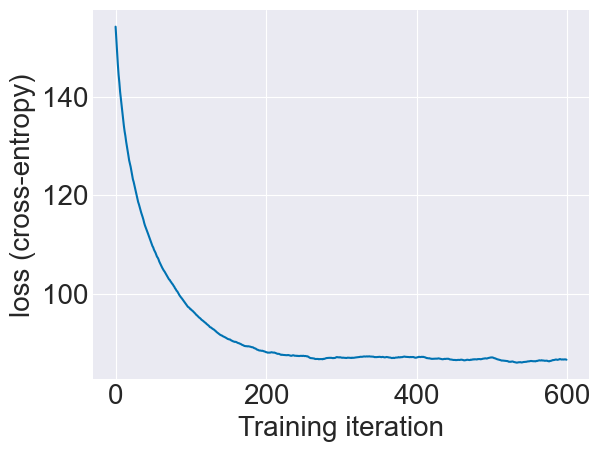

In [11]:
# YOUR CODE HERE

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev,
                              n_epochs=600,
                              mini_batch_sz=250,
                              r_seed=0, reg=100)

plot_cross_entropy_loss(loss_history)



**Question 3.** Play around with the batch size parameter.

(i) How does this affect the training loss and **why**? (*Think about the error gradient and how the weights change*)

(ii) Make a plot that showcases the effect of large mini-batch size.

(iii) Make a plot that showcases the effect of small mini-batch size.

**Answer 3:**

A smaller batch results in a very very noisy curve due to much more frequent, but rougher updates to the gradient (since very small batches may not represent the entire data well). The weights also update more frequently, which can help escape local minima, but may result in a less-than-ideal loss. Smaller batches do however have the benefit of possibly converging faster due to the more frequent updates, and also require less memory.

For larger batches, the opposite applies. The gradient and weight updates are slower, but each update is more accurate as larger batches represent the whole dataset more accurately. As a result, there is less extreme noise across the curve, and larger batches may converge more smoothly but slower, while using more memory.

Iteration 100/600, Loss: 0.0878
Iteration 200/600, Loss: 0.0430
Iteration 300/600, Loss: 0.0259
Iteration 400/600, Loss: 0.0197
Iteration 500/600, Loss: 0.0153
Iteration 600/600, Loss: 0.0128
Training completed. 600 epochs, 1 iterations per epoch.


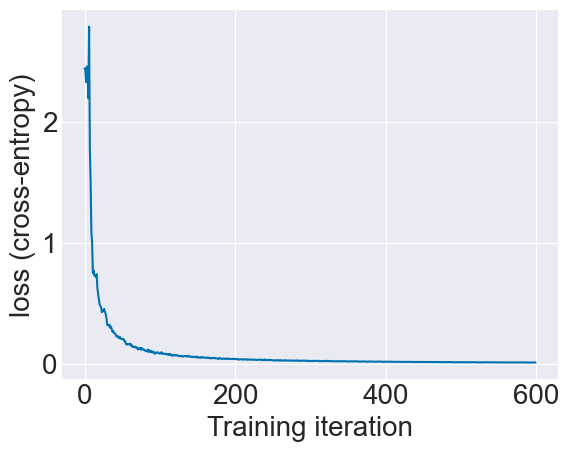

Iteration 100/3000, Loss: 0.8010
Iteration 200/3000, Loss: 0.4625
Iteration 300/3000, Loss: 0.3444
Iteration 400/3000, Loss: 0.2176
Iteration 500/3000, Loss: 0.1875
Iteration 600/3000, Loss: 0.1938
Iteration 700/3000, Loss: 0.1172
Iteration 800/3000, Loss: 0.1210
Iteration 900/3000, Loss: 0.1169
Iteration 1000/3000, Loss: 0.1008
Iteration 1100/3000, Loss: 0.0764
Iteration 1200/3000, Loss: 0.0935
Iteration 1300/3000, Loss: 0.0836
Iteration 1400/3000, Loss: 0.0735
Iteration 1500/3000, Loss: 0.0554
Iteration 1600/3000, Loss: 0.0535
Iteration 1700/3000, Loss: 0.0457
Iteration 1800/3000, Loss: 0.0508
Iteration 1900/3000, Loss: 0.0467
Iteration 2000/3000, Loss: 0.0433
Iteration 2100/3000, Loss: 0.0426
Iteration 2200/3000, Loss: 0.0372
Iteration 2300/3000, Loss: 0.0287
Iteration 2400/3000, Loss: 0.0425
Iteration 2500/3000, Loss: 0.0298
Iteration 2600/3000, Loss: 0.0346
Iteration 2700/3000, Loss: 0.0294
Iteration 2800/3000, Loss: 0.0322
Iteration 2900/3000, Loss: 0.0309
Iteration 3000/3000, Lo

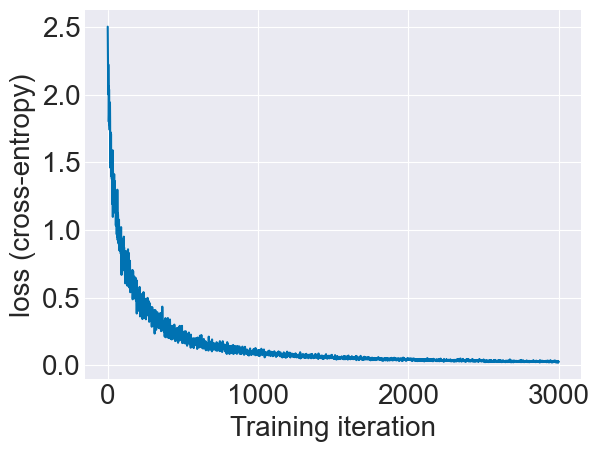

In [12]:
# YOUR CODE HERE

#large batch size
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev,
                              n_epochs=600,
                              mini_batch_sz=500,
                              r_seed=0)

plot_cross_entropy_loss(loss_history)


#small batch size
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev,
                              n_epochs=600,
                              mini_batch_sz=50,
                              r_seed=0)

plot_cross_entropy_loss(loss_history)

### 2e. Retraining the same net

Train 7 fresh softmax networks with default hyperparameters, except for `verbose=0`. Use the actual training set to train the networks rather than the dev set. Each time, compute and record the accuracy on the test set. After the 7 training sessions are over, print out all 7 accuracies.

In [13]:
# YOUR CODE HERE

def train_multiple_softmax_networks(X_train, y_train, X_test, y_test, num_networks=7, num_classes=10):
    accuracies = []
    
    for i in range(num_networks):
        print(f"Training network {i+1}/{num_networks}")
        
        # Initialize a new SoftmaxLayer
        network = SoftmaxLayer(num_classes)
        
        # Train the network
        network.fit(X_train, y_train, verbose=0)
        
        
        # Make predictions on the test set
        y_pred = network.predict(X_test)
        
        # Compute and record the accuracy
        accuracy = network.accuracy(y_test, y_pred)
        accuracies.append(accuracy)
        
        print(f"Network {i+1} test accuracy: {accuracy:.4f}")
    
    print("\nAll accuracies:")
    for i, acc in enumerate(accuracies, 1):
        print(f"Network {i}: {acc:.4f}")
    
    return accuracies

accuracies = train_multiple_softmax_networks(x_train, y_train, x_test, y_test)


Training network 1/7
Network 1 test accuracy: 0.3213
Training network 2/7
Network 2 test accuracy: 0.3400
Training network 3/7
Network 3 test accuracy: 0.3053
Training network 4/7
Network 4 test accuracy: 0.3280
Training network 5/7
Network 5 test accuracy: 0.3160
Training network 6/7
Network 6 test accuracy: 0.3280
Training network 7/7
Network 7 test accuracy: 0.3227

All accuracies:
Network 1: 0.3213
Network 2: 0.3400
Network 3: 0.3053
Network 4: 0.3280
Network 5: 0.3160
Network 6: 0.3280
Network 7: 0.3227


### 2f. Questions

**Question: 4:** What do you notice about the accuracies? Is this what you expected? Why does this happen?

**Answer 4:**

Accuracy is rather low across the board and very consistent despite random initializations (which are proven random by the slight discrepancies in accuracies). The hyperparameters chosen, such as learning rate, regularization, batch size, and epochs all play a part in determining accuracy. As such, I did not expect the defaults to necessarily produce the best results, even if running it multiple times with slight deviations due to randomness.

### 2g. Train and optimize STL-10 dataset performance

As you've surely noticed, hyperparameters can drastically affect learning! 


Implement a grid search for the best **combinations** of hyperparameters

- learning rate,
- regularization
- batch size 

Fix the training duration to `75` epochs.

The grid search process should:

1. Fit the model with specific values of hyperparameters that we're testing (using the training set).
2. Compute the accuracy on the **training set**. 
3. Compute the accuracy on the **validation set.** 
4. Print out and record the best parameter combination as you go (that *improves* the **validation set accuracy**).
5. Wipe the weights clean (reinitialize them) every time you try new parameters. It's easiest just to create a new net object on each run.

Configure your search *in the way that we prefer from class* so that you get reproducible accuracy. For example, if your search prints out that the best hyperparameters give X% accuracy in the search, training a net with those same hyperparameters after the search is completed also gives you X% accuracy.

#### Suggestions

This can take quite a bit of simulation time! Here are some tips:
- I suggest using a coarse-to-fine search strategy. Try varying hyperparameters over many orders of magnitude, then follow up with a 2nd search that "zooms in" around the hyperparameters that gave you the best results from the first search, as determined by your print outs. You can be informal about this and hard-code the coarse and fine hyperparameter choices. Abort searches prematurely if you feel there aren't productive (no reason to wait!). This can take however long or short that you want to dedicate. Remember, you are printing out the best parameter values on each run, so you can always just proceed with those.
- High learning rates don't really make sense. You'll know if your value is "high" if numpy complains about numerical issues.
- Your mini-batch sizes should be `<= N` and `>= 1`.
- Time single network runs with a few different batch sizes you plan on trying in your big search. This will help you figure out a ballpark estimate how long grid search will take (*you can decide whether to go eat dinner, run it overnight, etc.*). If it will take an unreasonable amount of time, reduce the number of parameters you try in one search.
- Think about whether you need *3 nested loops* or *a sequence of single loops*.
- Turn off print outs from `fit` (adjust `verbose` argument) and only print out things related to your search.
- Feel free to try a search with more than 75 training epochs for potentially better accuracy, but note that the search will take longer to complete.

**Important note:** I am not grading based on the number of hours your computer spends searching. I want to see that you successfully implemented the grid search to find progressively better hyperparameters on STL-10 and use the outcome to inform your ultimate training session that you use to evaluate predictions on the test set. You should be able to achieve ~30% accuracy without too much effort. *Getting full credit here does not require you spending hours of searching!*

In [15]:
list_learing_rate = [0.0001, 0.001, 0.01, 0.1]
list_reg = [0.0001, 0.001, 0.01, 0.1]
list_batch = [8, 16, 32, 64, 128, 256, 512, 1024]
best_accuracy_train = 0
best_accuracy_val = 0 
best_params = {}
num_epochs = 75

for rate in list_learing_rate:
    for reg in list_reg:
        for batch in list_batch:
            soft_mx = SoftmaxLayer(10)
            soft_mx.fit(x_train, y_train, num_epochs, rate, batch, reg, 0)
            y_pred_val = soft_mx.predict(x_val)
            y_pred_train = soft_mx.predict(x_train) 
            acc_val = soft_mx.accuracy(y_val, y_pred_val)
            acc_train = soft_mx.accuracy(y_train, y_pred_train)
            if acc_val >= best_accuracy_val:
                best_accuracy_val = acc_val
                best_accuracy_train = acc_train
                best_params = {"learning_rate": rate, "regularization": reg, "batch_size": batch}
                print("train accuracy:", acc_train)
                print("val accuracy:", best_accuracy_val)
                print("batch_size:", batch, "reg:", reg, "rate:", rate)

# Print the final best hyperparameters and accuracies
print("\nGrid search complete!")
print(f"Best training accuracy: {best_accuracy_train:.4f}")
print(f"Best validation accuracy: {best_accuracy_val:.4f}")
print(f"Best hyperparameters: {best_params}")

Iteration 100/28125, Loss: 1.8595
Iteration 200/28125, Loss: 1.8634
Iteration 300/28125, Loss: 2.0717
Iteration 400/28125, Loss: 2.4736
Iteration 500/28125, Loss: 1.8111
Iteration 600/28125, Loss: 1.2603
Iteration 700/28125, Loss: 1.6679
Iteration 800/28125, Loss: 1.7684
Iteration 900/28125, Loss: 1.5445
Iteration 1000/28125, Loss: 1.7632
Iteration 1100/28125, Loss: 1.4726
Iteration 1200/28125, Loss: 1.1918
Iteration 1300/28125, Loss: 2.0740
Iteration 1400/28125, Loss: 1.2419
Iteration 1500/28125, Loss: 1.2564
Iteration 1600/28125, Loss: 1.3445
Iteration 1700/28125, Loss: 2.1064
Iteration 1800/28125, Loss: 1.6153
Iteration 1900/28125, Loss: 1.0887
Iteration 2000/28125, Loss: 1.6504
Iteration 2100/28125, Loss: 1.5239
Iteration 2200/28125, Loss: 1.4765
Iteration 2300/28125, Loss: 1.5754
Iteration 2400/28125, Loss: 1.7352
Iteration 2500/28125, Loss: 1.1495
Iteration 2600/28125, Loss: 1.6986
Iteration 2700/28125, Loss: 1.6046
Iteration 2800/28125, Loss: 1.7368
Iteration 2900/28125, Loss: 1

### 2h. Verify reproducibility of results  

Train a fresh net with the best hyperparameter values that you found in your search give you the best validation accuracy above.

Print out the accuracy on the validation set. It should match exactly your printout above.

In [22]:
# Best hyperparameters from the grid search
best_learning_rate = 0.0001
best_regularization = 0.1
best_batch_size = 256
num_epochs = 75  # Training duration

# Initialize a new softmax model
softmax_model = SoftmaxLayer(10)

# Train the model using the best hyperparameters
softmax_model.fit(x_train, y_train, num_epochs, best_learning_rate, best_batch_size, best_regularization, verbose=0, r_seed = 0)

# Make predictions on the validation set
y_val_pred = softmax_model.predict(x_val)

# Compute accuracy on the validation set
val_accuracy = softmax_model.accuracy(y_val, y_val_pred)

# Print the validation accuracy
print(f"Validation accuracy with best hyperparameters: {val_accuracy:.4f}")


Validation accuracy with best hyperparameters: 0.3330


### 2i. Evaluate best model on test set

**Question 5:** Now that you have "good" parameter values recorded, train a new model with the best learning rate, regularization strength, and batch size values in the cell below. What accuracy do you get on the **test set**? How does this compare to chance performance?

*Recall: The test set should NOT be used in your grid search. It should only be processed once AFTER you conclude your grid search.*

**Answer 5:**

33.60%, which is slightly higher than the 33.30% from the validation set. In this case, since there are 10 classes, there is a 10% chance if randomly guessing by chance, so model accuracy is significantly higher.

In [26]:
batch_size = 256
regularization = 0.1
learning_rate = 0.0001
num_epochs = 75

bestNet = SoftmaxLayer(10)

bestNet.fit(x_train, y_train, num_epochs, learning_rate, batch_size, regularization, verbose=1, r_seed = 0)

y_val_pred = bestNet.predict(x_val)
y_train_pred = bestNet.predict(x_train)
y_test_pred = bestNet.predict(x_test)

test_accuracy = bestNet.accuracy(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


Iteration 100/825, Loss: 1.5763
Iteration 200/825, Loss: 1.5532
Iteration 300/825, Loss: 1.4926
Iteration 400/825, Loss: 1.5757
Iteration 500/825, Loss: 1.5435
Iteration 600/825, Loss: 1.5947
Iteration 700/825, Loss: 1.6503
Iteration 800/825, Loss: 1.7705
Training completed. 75 epochs, 11 iterations per epoch.
Test set accuracy: 0.3360


### 2j. Visualize learned weights

Run the following code that plots the network weights going to each output neuron. If all goes well, you should see something really cool! Include the plot in your submitted project to show me what you got!

**Note:** the quality of your visualizations will depend on:
- The quality of the hyperparameters that you got via grid search.
- How many epochs that you trained the network before plotting the weights

One extension idea: is to find the combination of the above that result in the best visualizations.

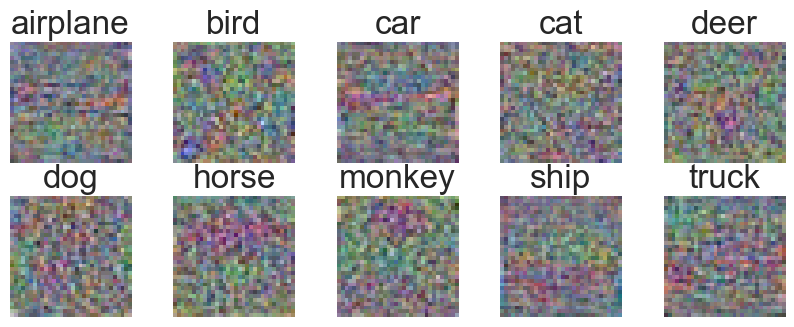

In [27]:
# Load in the class names
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

# We don't care about the bias wt
wts = bestNet.wts
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(10, 4))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)

  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))

  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.subplots_adjust(wspace=0.35, hspace=0)
plt.show()